<a href="https://colab.research.google.com/github/mvince33/Coding-Dojo/blob/main/project2/project2_part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 - Part 4
- Michael Vincent
- 8/23/22


## Code For Part 2

### Imports

In [105]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(display = 'diagram')

### Load the data

The original data set can be found [here](https://archive.ics.uci.edu/ml/datasets/Secondary+Mushroom+Dataset)

In [106]:
# Load the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSu_3xbzvwqg6MpBKKDB3u8YHK31h6CTK5z1MClZorpRvHz4gTYJdv3IrrdSzwBA3gHuxlY7hsShEpZ/pub?output=csv'
df = pd.read_csv(url)
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


### Clean the data

#### Duplicates

In [107]:
# Look for duplicates
print('Duplicates:', df.duplicated().sum())

# Remove the duplicates
df.drop_duplicates(inplace = True)

# Make sure the duplicate values were dropped
print('Duplicates:', df.duplicated().sum())

Duplicates: 146
Duplicates: 0


#### Missing values
- A seprate DataFrame for machine learning was constructed in this cell block.
- All missing values were categorical. The labels in this data set are all single lower case letters. The missing values were imputed with the value 'M'. 

In [108]:
# Check for missing values
print('Missing Values:', df.isna().sum().sum())

# Find missing values by column
print(df.isna().sum())
print('-' * 80)

# Get the percentage of missing data in each row
for col, n in zip(df.isna().sum().index, df.isna().sum().values):
  if n > 0:
    print(f'Percentage of data missing in {col}: {round(n / len(df) * 100, 2)}')

Missing Values: 307019
class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9855
gill-spacing            25062
gill-color                  0
stem-height                 0
stem-width                  0
stem-root               51536
stem-surface            38122
stem-color                  0
veil-type               57746
veil-color              53510
has-ring                    0
ring-type                2471
spore-print-color       54597
habitat                     0
season                      0
dtype: int64
--------------------------------------------------------------------------------
Percentage of data missing in cap-surface: 23.18
Percentage of data missing in gill-attachment: 16.18
Percentage of data missing in gill-spacing: 41.14
Percentage of data missing in stem-root: 84.59
Percentage of data missing in stem-surface: 62.57
Perc

> We see the columns stem-root, stem-surface, veil-type, veil-color, and spore-print-color all have more than 60% of their values missing. We will drop these columns since it seems unwise to impute such a large amount of data.

In [109]:
# Drop the columns with more than 60% of the data missing.
df.dropna(axis = 1, thresh = int(0.4*len(df)), inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60923 entries, 0 to 61068
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 60923 non-null  object 
 1   cap-diameter          60923 non-null  float64
 2   cap-shape             60923 non-null  object 
 3   cap-surface           46803 non-null  object 
 4   cap-color             60923 non-null  object 
 5   does-bruise-or-bleed  60923 non-null  object 
 6   gill-attachment       51068 non-null  object 
 7   gill-spacing          35861 non-null  object 
 8   gill-color            60923 non-null  object 
 9   stem-height           60923 non-null  float64
 10  stem-width            60923 non-null  float64
 11  stem-color            60923 non-null  object 
 12  has-ring              60923 non-null  object 
 13  ring-type             58452 non-null  object 
 14  habitat               60923 non-null  object 
 15  season             

In [110]:
# Before we impute, we will make a separate copy of the
# DataFrame for machine learning.
ml_df = df.copy()

# The remaning missing values will be imputed with 'M'. A separate copy
# of the data will be used for machine learning so the we don't risk data leakage.
df.fillna('M', inplace = True)

# Check to make sure missing values have been filled.
print('Missing Values:', df.isna().sum().sum())

Missing Values: 0


> We chose to impute missing values with 'M' in the case where less than 80%, and more than 20% of the data was missing. We felt more than 80% of the values of an attribute being missing would not contribute much to our model. In the case of 20-80% of the data missing we feel that a label that indicates the data is missing may be beneficial to our model. We will revisit these assumptions in the event that we are not able to construct a model that scores well on this data.

#### Inconsistent labels

In [111]:
# Check for inconsistent labels
cat_cols = df.select_dtypes(include = 'object')
for col in cat_cols:
  print('Column:', col)
  print(df[col].value_counts(normalize = True))
  print()

Column: class
p    0.553847
e    0.446153
Name: class, dtype: float64

Column: cap-shape
x    0.442066
f    0.220015
s    0.117591
b    0.093462
o    0.054429
p    0.042644
c    0.029792
Name: cap-shape, dtype: float64

Column: cap-surface
M    0.231768
t    0.134334
s    0.124419
y    0.104082
h    0.081644
g    0.077508
d    0.072748
e    0.042414
k    0.037802
i    0.036522
w    0.035290
l    0.021470
Name: cap-surface, dtype: float64

Column: cap-color
n    0.397305
y    0.140193
w    0.125552
g    0.070778
e    0.066231
o    0.059961
r    0.029201
u    0.028052
p    0.027953
k    0.020994
b    0.020189
l    0.013591
Name: cap-color, dtype: float64

Column: does-bruise-or-bleed
f    0.826174
t    0.173826
Name: does-bruise-or-bleed, dtype: float64

Column: gill-attachment
a    0.208411
d    0.168196
M    0.161762
x    0.121678
p    0.098501
e    0.092707
s    0.092707
f    0.056038
Name: gill-attachment, dtype: float64

Column: gill-spacing
M    0.411372
c    0.405134
d    0.127456

> There do not appear to be any inconsistencies in our labels.

#### Outliers

In [112]:
# Get the descriptive stats of the numeric data
df.describe()

,cap-diameter,stem-height,stem-width
count,60923.000000,60923.000000,60923.000000
mean,6.741957,6.597202,12.178484
std,5.268435,3.358757,10.030361
min,0.380000,0.000000,0.000000
25%,3.490000,4.650000,5.250000
50%,5.880000,5.960000,10.220000
75%,8.550000,7.750000,16.580000
max,62.340000,33.920000,103.910000


> There are values in 'stem-height' and 'stem-width' that are set to 0. We will investigate these data points more closely.

In [113]:
# Find the rows with 'stem-heigh' equal to 0.
display(df[df['stem-height'] == 0])

# Find the number of entries in 'stem-height' and
# 'stem-width' equal to 0
print(len(df[df['stem-height'] == 0]))
print(len(df[df['stem-width'] == 0]))

# Find the number of rows where exactly one of 'stem-heigh'
# and 'stem-width' is equal to 0
print(len(df[(df['stem-height'] == 0) & (df['stem-width'] != 0)]))
print(len(df[(df['stem-height'] != 0) & (df['stem-width'] == 0)]))

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
56480,p,2.48,o,t,n,f,M,c,w,0.0,0.0,f,f,f,d,u
56481,p,4.29,o,t,w,f,M,c,w,0.0,0.0,f,f,f,d,u
56482,p,4.29,o,t,n,f,M,c,w,0.0,0.0,f,f,f,d,u
56483,p,4.72,o,t,w,f,M,c,w,0.0,0.0,f,f,f,d,u
56484,p,4.66,o,t,w,f,M,c,w,0.0,0.0,f,f,f,d,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58234,p,2.21,o,l,g,f,f,f,f,0.0,0.0,f,f,f,d,w
58235,p,3.34,o,l,g,f,f,f,f,0.0,0.0,f,f,f,d,w
58238,p,2.28,o,l,g,f,f,f,f,0.0,0.0,f,f,f,d,a
58240,p,2.54,o,l,g,f,f,f,f,0.0,0.0,f,f,f,d,u


915
915
0
0


> Based on the above we assume that a 0 for stem-height and stem-width just means the mushroom under consideration doesn't have a stem.

In [114]:
# Check the relatively large values
df.loc[df['stem-width'] > 60, ['cap-diameter', 'stem-height', 'stem-width']]

,cap-diameter,stem-height,stem-width
48361,13.80,17.93,70.21
48362,17.63,17.55,69.37
48363,22.40,15.59,69.47
48364,24.73,16.28,65.87
48365,22.83,16.90,70.92
...,...,...,...
55400,4.90,6.56,62.04
55404,5.78,7.42,73.28
55407,4.39,7.43,67.74
55412,5.32,8.56,61.74


> We would need to consult subject-matter expert to determine if any of these data points are unlikely. So we choose to not alter the numeric data.

### Data Visualizations

#### Histograms

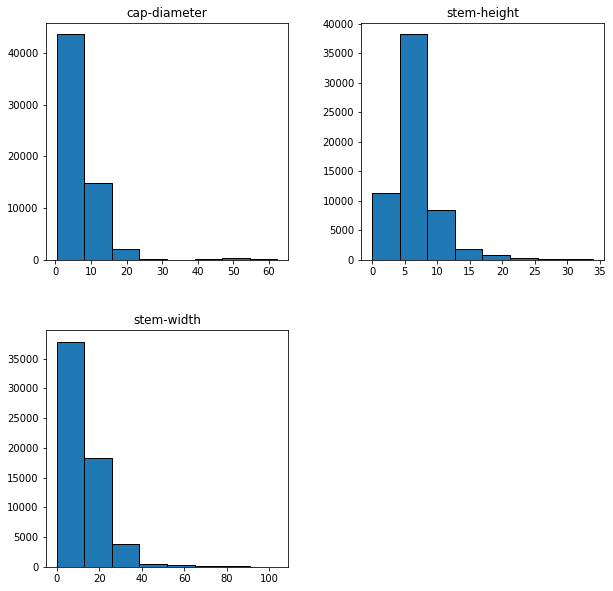

In [115]:
# Make histograms for the numeric features
df.hist(grid = False,
        edgecolor = 'k',
        figsize = (10, 10),
        bins = 8);

#### Bar graphs

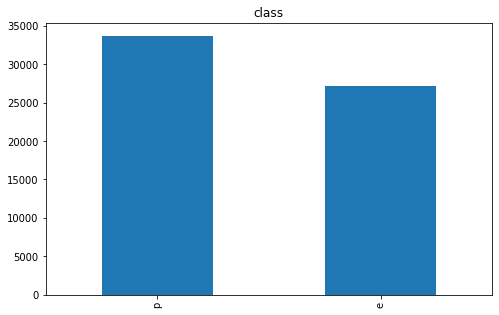

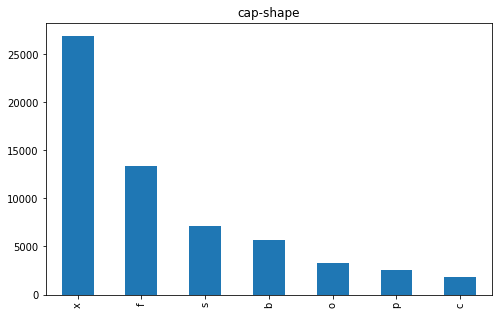

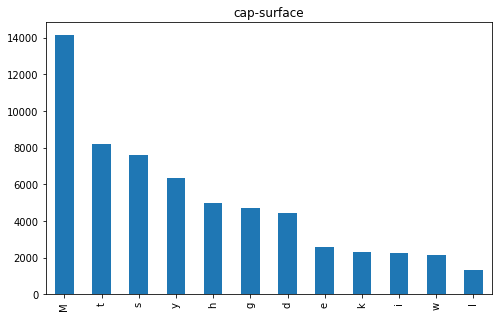

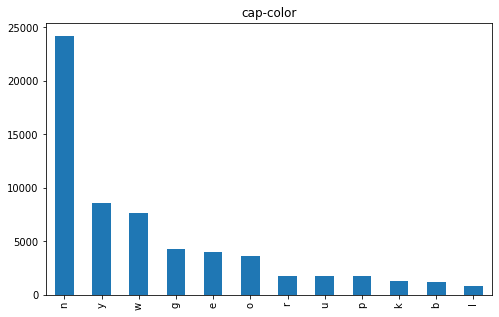

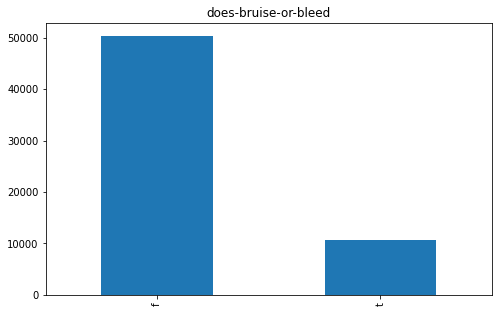

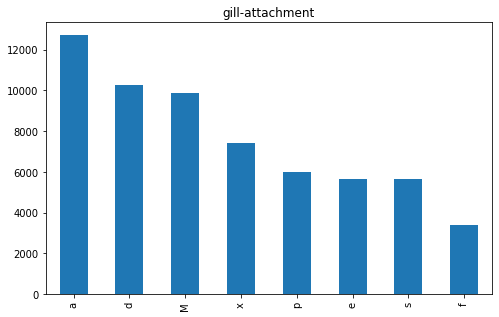

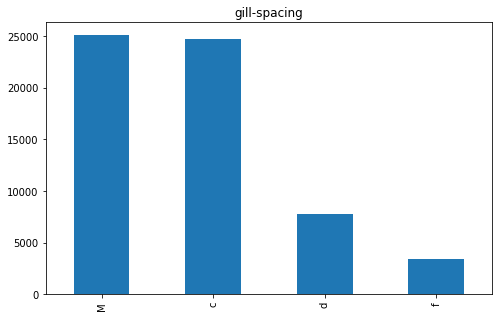

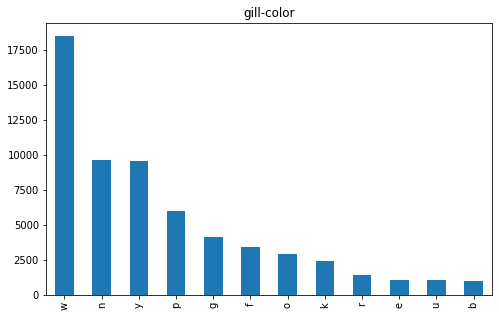

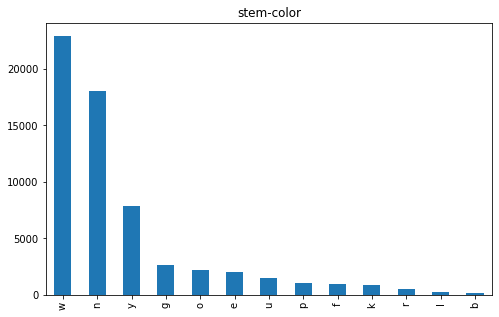

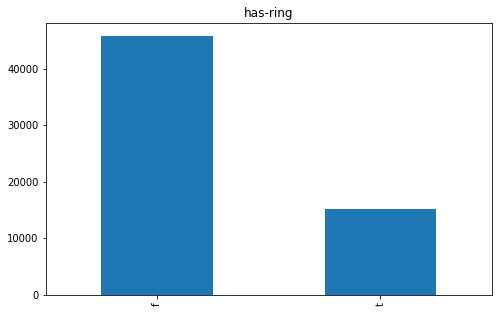

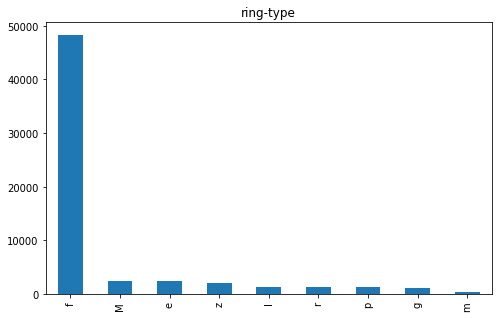

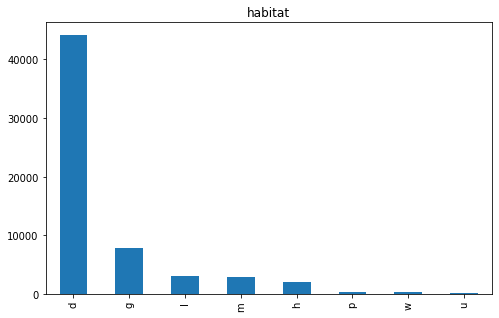

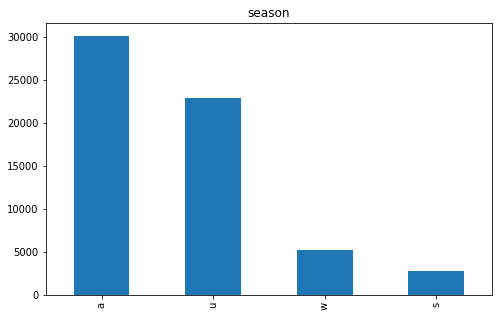

In [116]:
# Plot the categorical data using bar graphs.
for col in df.select_dtypes(include = 'object'):
  plt.figure(figsize = (8, 5));
  df[col].value_counts().plot.bar(title = col);
  plt.show();
  print()

#### Multivariate visualizations
> Multivariate visulizations were included to try and gain a deeper insight into the data.

##### Heatmap

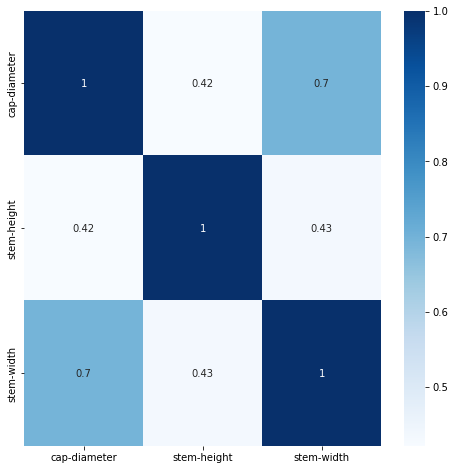

In [117]:
# Check for correlations in the numeric features
corr = df.corr()
plt.figure(figsize = (8, 8));
sns.heatmap(corr, cmap = 'Blues', annot = True);

> There is a moderate correlation between cap-diameter and stem-width.

##### Scatterplots

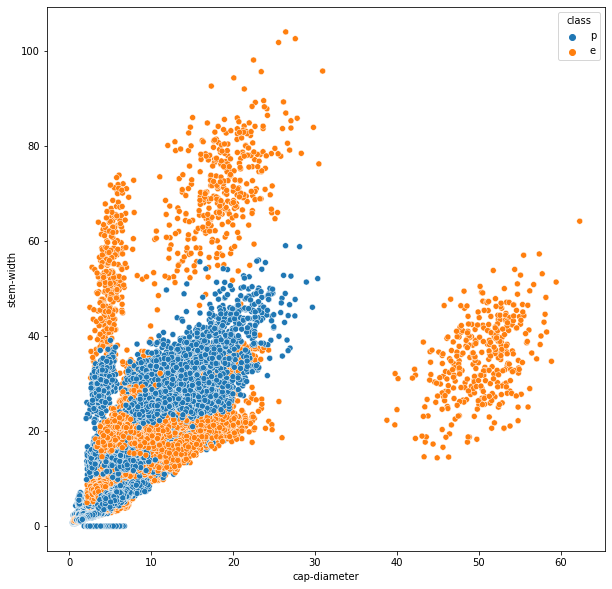

In [118]:
# Construct a scatter plot of stem-width vs. cap-diameter. The 
# hue is class.
plt.figure(figsize = (10, 10))
sns.scatterplot(x = df['cap-diameter'], 
            y = df['stem-width'],
            hue = df['class']);

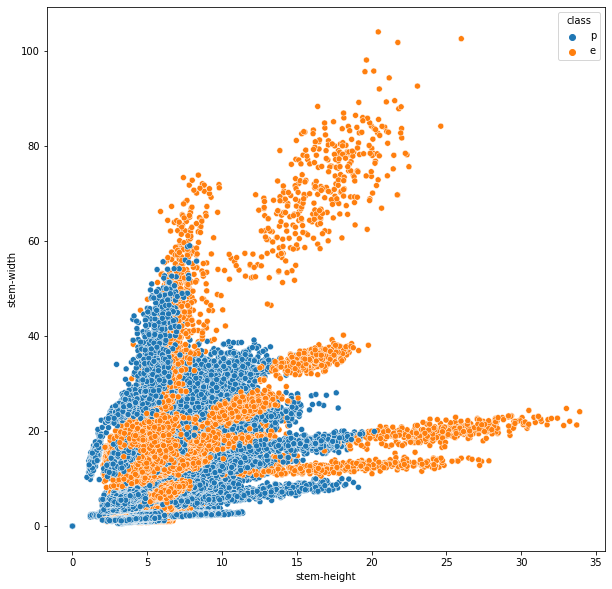

In [119]:
# Construct a scatter plot of stem-height vs. cap-diameter. The 
# hue is class.
plt.figure(figsize = (10, 10))
sns.scatterplot(x = df['stem-height'], 
            y = df['stem-width'],
            hue = df['class']);

> These scatterplots suggest that larger mushrooms are edible. (Please don't test this hypothesis!) If we find that our model is performing poorly, we may consider removing mushrooms with larger stem-heights, stem-widths, and cap-diameters.

##### Bar graphs

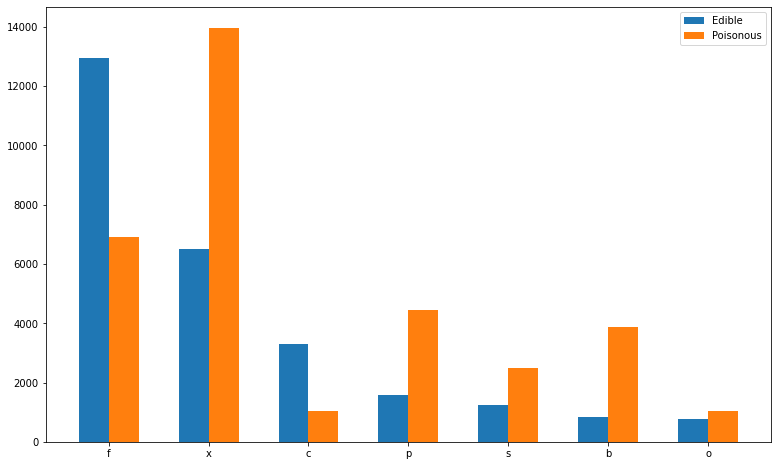

In [120]:
# Plot a bar graph for counts of each cap-shape by class.
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13, 8))
ax.bar(x = df.loc[df['class'] == 'e', 'cap-shape'].unique(), 
       height = df.loc[df['class'] == 'e', 'cap-shape'].value_counts(),
       width = -0.3, align = 'edge',
       label = 'Edible')
ax.bar(x = df.loc[df['class'] == 'p', 'cap-shape'].unique(),
       height = df.loc[df['class'] == 'p', 'cap-shape'].value_counts(),
       width = 0.3, align = 'edge',
       label = 'Poisonous')
ax.legend();

> This graph suggests that mushrooms with a convex cap-shape are most likely to be poisonous. Both poisonous and edible mushrooms are present in each cap-shape.

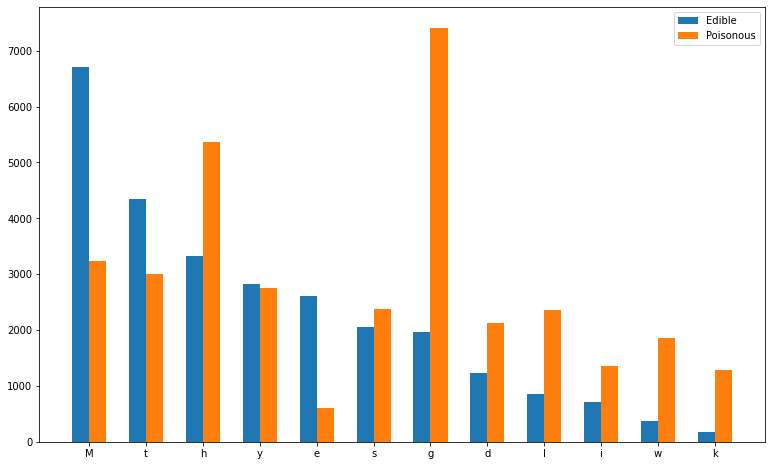

In [121]:
# Plot a bar graph for counts of each cap-surface by class.
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13, 8))
ax.bar(x = df.loc[df['class'] == 'e', 'cap-surface'].unique(), 
       height = df.loc[df['class'] == 'e', 'cap-surface'].value_counts(),
       width = -0.3, align = 'edge',
       label = 'Edible')
ax.bar(x = df.loc[df['class'] == 'p', 'cap-surface'].unique(),
       height = df.loc[df['class'] == 'p', 'cap-surface'].value_counts(),
       width = 0.3, align = 'edge',
       label = 'Poisonous')
ax.legend();

> This bar graph suggests that mushrooms with a grooved cap-surfaces ar the most likely to be poisonous. We again see that both poisonous and edible mushrooms are represented in each cap-surface.

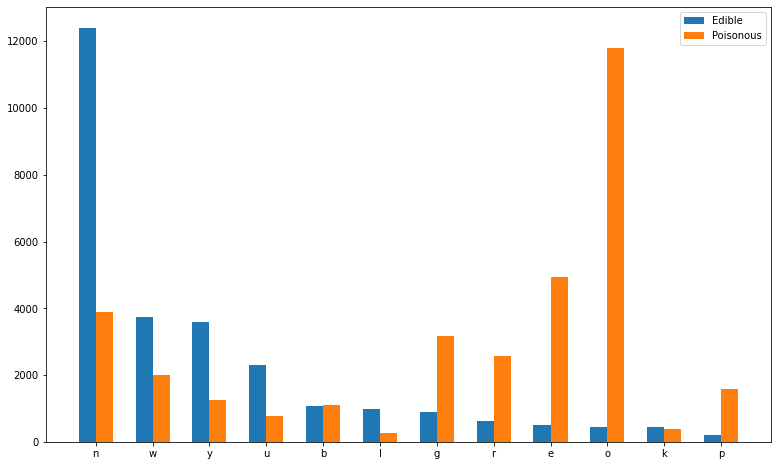

In [122]:
# Plot a bar graph for counts of each cap-color by class.
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13, 8))
ax.bar(x = df.loc[df['class'] == 'e', 'cap-color'].unique(), 
       height = df.loc[df['class'] == 'e', 'cap-color'].value_counts(),
       width = -0.3, align = 'edge',
       label = 'Edible')
ax.bar(x = df.loc[df['class'] == 'p', 'cap-color'].unique(),
       height = df.loc[df['class'] == 'p', 'cap-color'].value_counts(),
       width = 0.3, align = 'edge',
       label = 'Poisonous')
ax.legend();

> This graph suggests that gray, green, red, and orange muschrooms tend to be the most poisonous. Orange mushrooms in particular seem to be largely poisonous.

## Code For Part 3



### Relabel the data

In order to make our graphs more readable, we will make the labels more clear in our DataFrame. Note that the data dictionary did not give a value associated with the letter 'd' in the cap-surface column.

In [123]:
# Get the column names of the categorical data
df.select_dtypes(include = 'object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60923 entries, 0 to 61068
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   class                 60923 non-null  object
 1   cap-shape             60923 non-null  object
 2   cap-surface           60923 non-null  object
 3   cap-color             60923 non-null  object
 4   does-bruise-or-bleed  60923 non-null  object
 5   gill-attachment       60923 non-null  object
 6   gill-spacing          60923 non-null  object
 7   gill-color            60923 non-null  object
 8   stem-color            60923 non-null  object
 9   has-ring              60923 non-null  object
 10  ring-type             60923 non-null  object
 11  habitat               60923 non-null  object
 12  season                60923 non-null  object
dtypes: object(13)
memory usage: 6.5+ MB


In [124]:
# Relabel the class column
df['class'].replace({'e': 'edible', 'p': 'poisonous'}, inplace = True)
# Make sure the changes were made
df['class'].value_counts()

poisonous    33742
edible       27181
Name: class, dtype: int64

In [125]:
# Relabel the cap-shape column
df['cap-shape'].replace({'b': 'bell',
                         'c': 'conical',
                         'x': 'convex',
                         'f': 'flat',
                         's': 'sunken',
                         'p': 'spherical',
                         'o': 'other'},
                        inplace = True)
# Make sure the changes were made
df['cap-shape'].value_counts()

convex       26932
flat         13404
sunken        7164
bell          5694
other         3316
spherical     2598
conical       1815
Name: cap-shape, dtype: int64

In [126]:
# Relabel the cap-surface column
df['cap-surface'].replace({'i': 'fibrous',
                           'g': 'grooves',
                           'y': 'scaly',
                           's': 'smooth',
                           'h': 'shiny',
                           'l': 'leathery',
                           'k': 'silky',
                           't': 'sticky',
                           'w': 'wrinlked',
                           'e': 'fleshy',
                           'M': 'missing'},
                          inplace = True)
df['cap-surface'].value_counts()

missing     14120
sticky       8184
smooth       7580
scaly        6341
shiny        4974
grooves      4722
d            4432
fleshy       2584
silky        2303
fibrous      2225
wrinlked     2150
leathery     1308
Name: cap-surface, dtype: int64

> We could not find an attribute with the label 'd' at the UCI website where we found this data. We will leave that label as it is for now.

In [127]:
# Relabel the cap-color column
df['cap-color'].replace({'n': 'brown',
                         'b': 'buff',
                         'g': 'gray',
                         'r': 'green',
                         'p': 'pink',
                         'u': 'purple',
                         'e': 'red',
                         'w': 'white',
                         'y': 'yellow',
                         'l': 'blue',
                         'o': 'orange',
                         'k': 'black'},
                        inplace = True)
# Make sure the changes were made
df['cap-color'].value_counts()

brown     24205
yellow     8541
white      7649
gray       4312
red        4035
orange     3653
green      1779
purple     1709
pink       1703
black      1279
buff       1230
blue        828
Name: cap-color, dtype: int64

In [128]:
# Relabel the does-bruise-or-bleed column
df['does-bruise-or-bleed'].replace({'t': 'yes', 'f': 'no'}, inplace = True)
# Make sure the changes were made
df['does-bruise-or-bleed'].value_counts()

no     50333
yes    10590
Name: does-bruise-or-bleed, dtype: int64

In [129]:
# Relabel the gill-attachment column
df['gill-attachment'].replace({'a': 'adnate',
                               'x': 'adnexed',
                               'd': 'decurrent',
                               'e': 'free',
                               's': 'sinuate',
                               'p': 'pores',
                               'f': 'none',
                               'M': 'missing'},
                              inplace = True)
df['gill-attachment'].value_counts()

adnate       12697
decurrent    10247
missing       9855
adnexed       7413
pores         6001
free          5648
sinuate       5648
none          3414
Name: gill-attachment, dtype: int64

In [130]:
# Relabel the gill-spacing column
df['gill-spacing'].replace({'c': 'close',
                            'd': 'distant',
                            'f': 'none',
                            'M': 'missing'},
                           inplace = True)
# Make sure the changes were made
df['gill-spacing'].value_counts()

missing    25062
close      24682
distant     7765
none        3414
Name: gill-spacing, dtype: int64

In [131]:
# Relabel the gill-color column
df['gill-color'].replace({'n': 'brown',
                         'b': 'buff',
                         'g': 'gray',
                         'r': 'green',
                         'p': 'pink',
                         'u': 'purple',
                         'e': 'red',
                         'w': 'white',
                         'y': 'yellow',
                         'l': 'blue',
                         'o': 'orange',
                         'k': 'black',
                         'f': 'none'},
                        inplace = True)
df['gill-color'].value_counts()

white     18492
brown      9645
yellow     9545
pink       5983
gray       4118
none       3414
orange     2909
black      2375
green      1399
red        1066
purple     1023
buff        954
Name: gill-color, dtype: int64

In [132]:
# Relabel the stem-color column
df['stem-color'].replace({'n': 'brown',
                         'b': 'buff',
                         'g': 'gray',
                         'r': 'green',
                         'p': 'pink',
                         'u': 'purple',
                         'e': 'red',
                         'w': 'white',
                         'y': 'yellow',
                         'l': 'blue',
                         'o': 'orange',
                         'k': 'black',
                         'f': 'none'},
                        inplace = True)
df['stem-color'].value_counts()

white     22926
brown     18063
yellow     7864
gray       2626
orange     2187
red        2049
purple     1490
pink       1025
none        915
black       837
green       542
blue        226
buff        173
Name: stem-color, dtype: int64

In [133]:
# Relabel the has-ring column
df['has-ring'].replace({'t': 'yes', 'f': 'no'}, inplace = True)
# Make sure the values were changed
df['has-ring'].value_counts()

no     45756
yes    15167
Name: has-ring, dtype: int64

In [134]:
# Relabel the ring-type column
df['ring-type'].replace({'c': 'cobwebby',
                         'e': 'evanescent',
                         'r': 'flaring',
                         'g': 'grooved',
                         'l': 'large',
                         'p': 'pendant',
                         's': 'sheathing',
                         'z': 'zone',
                         'y': 'scaly',
                         'm': 'movable',
                         'f': 'none',
                         'M': 'missing'},
                        inplace = True)
df['ring-type'].value_counts()

none          48215
missing        2471
evanescent     2435
zone           2118
large          1427
flaring        1399
pendant        1265
grooved        1240
movable         353
Name: ring-type, dtype: int64

In [135]:
# Relabel the habitat column
df['habitat'].replace({'g': 'grasses',
                       'l': 'leaves',
                       'm': 'meadows',
                       'p': 'paths',
                       'h': 'heaths',
                       'u': 'urbane',
                       'w': 'waste',
                       'd': 'woods'},
                      inplace = True)
# Make sure the changes were made
df['habitat'].value_counts()

woods      44063
grasses     7943
leaves      3168
meadows     2920
heaths      2001
paths        360
waste        353
urbane       115
Name: habitat, dtype: int64

In [136]:
# Relabel the season column
df['season'].replace({'s': 'spring',
                      'u': 'summer',
                      'a': 'autumn',
                      'w': 'winter'},
                     inplace = True)
# Make sure the changes were made
df['season'].value_counts()

autumn    30141
summer    22850
winter     5233
spring     2699
Name: season, dtype: int64

In [137]:
# Make sure there are no columns left to relabel
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,poisonous,15.26,convex,grooves,orange,no,free,missing,white,16.95,17.09,white,yes,grooved,woods,winter
1,poisonous,16.60,convex,grooves,orange,no,free,missing,white,17.99,18.19,white,yes,grooved,woods,summer
2,poisonous,14.07,convex,grooves,orange,no,free,missing,white,17.80,17.74,white,yes,grooved,woods,winter
3,poisonous,14.17,flat,shiny,red,no,free,missing,white,15.77,15.98,white,yes,pendant,woods,winter
4,poisonous,14.64,convex,shiny,orange,no,free,missing,white,16.53,17.20,white,yes,pendant,woods,winter


### Heatmap

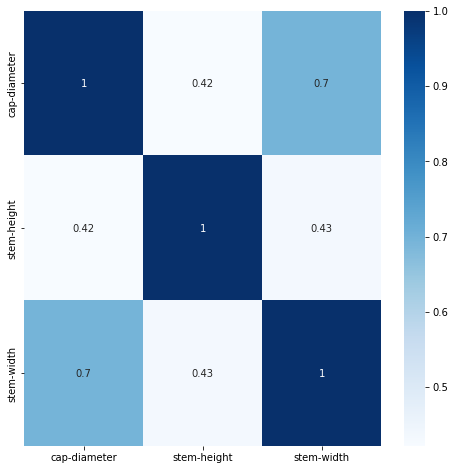

In [138]:
# Check for correlations in the numeric features
corr = df.corr()
plt.figure(figsize = (8, 8));
sns.heatmap(corr, cmap = 'Blues', annot = True);

> We see a moderate correlation between stem-width and cap-diameter, and a weaker correlation between stem-width and stem-height.

### Bar graphs for counts of edible and poisonous mushrooms for all the categorical columns

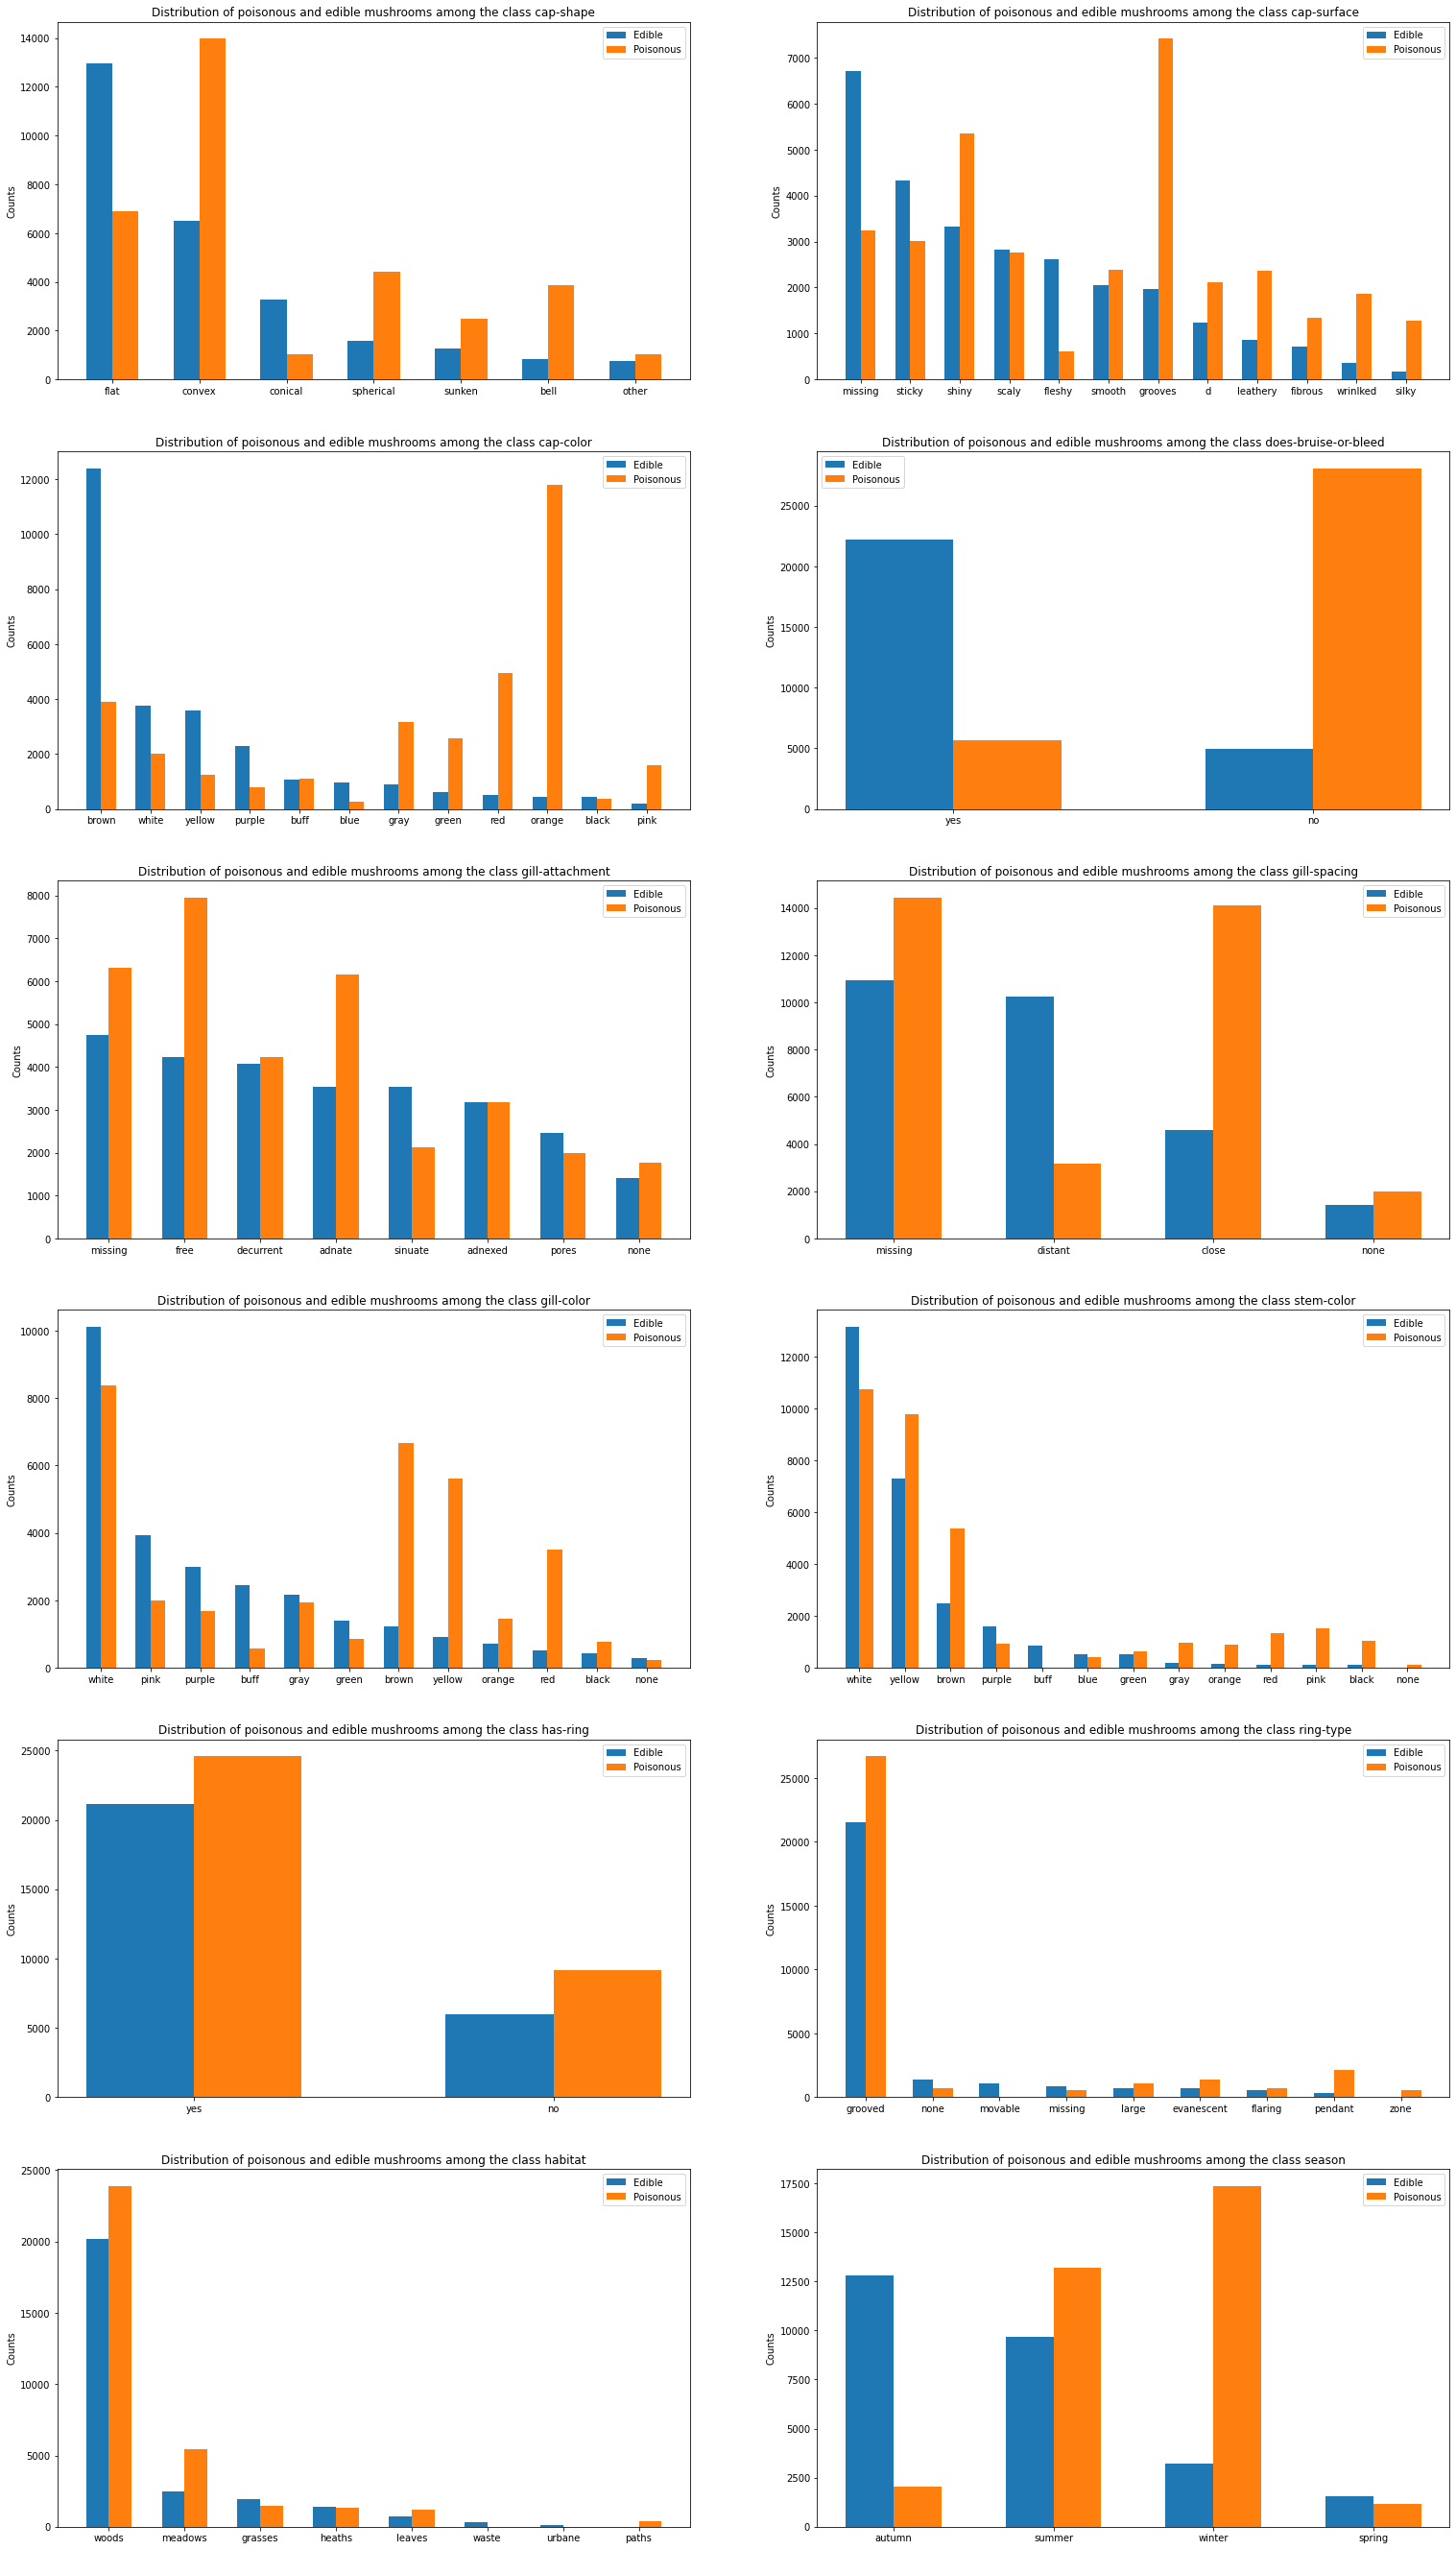

In [139]:
# Make bar graphs of the categarical data by class

# Get the categorical columns
cols = df.select_dtypes(include = 'object').columns
cols = cols.drop('class')

# Setup the plots
n = int(len(cols) / 2)
fig, axes = plt.subplots(nrows = n, ncols = 2, figsize = (26, 8*n))
axes = axes.ravel()

# Construct the bar graphs
for i, col in enumerate(cols):
  axes[i].bar(x = df.loc[df['class'] == 'edible', col].unique(), 
              height = df.loc[df['class'] == 'edible', col].value_counts(),
              width = -0.3, align = 'edge',
              label = 'Edible')
  axes[i].bar(x = df.loc[df['class'] == 'poisonous', col].unique(),
              height = df.loc[df['class'] == 'poisonous', col].value_counts(),
              width = 0.3, align = 'edge',
              label = 'Poisonous')
  axes[i].set_ylabel('Counts')
  axes[i].set_title(f'Distribution of poisonous and edible mushrooms among the class {col}')
  axes[i].legend();

### Bar graphs for the mean and median values of the numeric columns for poisonous and edible mushrooms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app


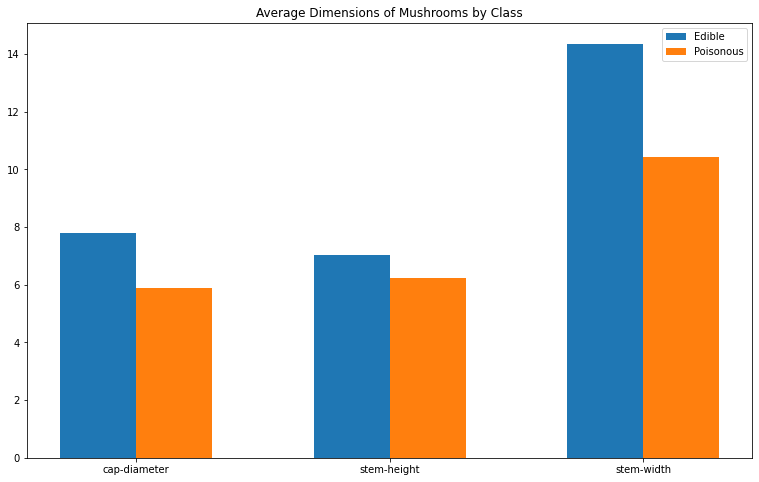

In [140]:
# Make plots for the average dimensions of poisonous and edible mushrooms.

# Get the numeric columns
cols = df.select_dtypes(include = 'number').columns

# Make a fliter for edible mushrooms
filter = df['class'] == 'edible'

# Construct the bar graphs
plt.figure(figsize = (13, 8));
plt.bar(x = cols, height = df.loc[filter, :].mean(), 
        label = 'Edible',
        width = -0.3,
        align = 'edge');
plt.bar(x = cols, height = df.loc[~filter, :].mean(), 
        label = 'Poisonous',
        width = 0.3,
        align = 'edge');
plt.title('Average Dimensions of Mushrooms by Class')
plt.legend();

> This bar graph suggests that the dimensions of a mushroom are not a good predictor of whether it is poisonous or not.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app


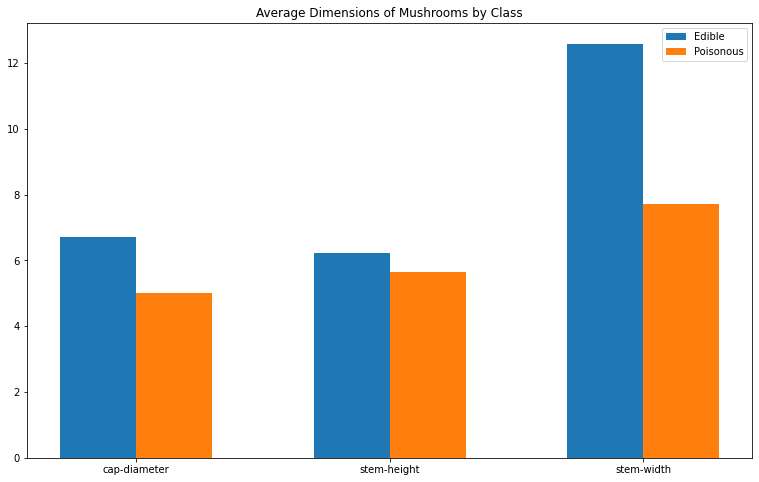

In [141]:
# Make plots for the median dimensions of poisounous and edible muschrooms.

# Get the numeric columns
cols = df.select_dtypes(include = 'number').columns

# Make a fliter for edible mushrooms
filter = df['class'] == 'edible'

# Construct the bar graphs
plt.figure(figsize = (13, 8));
plt.bar(x = cols, height = df.loc[filter, :].median(), 
        label = 'Edible',
        width = -0.3,
        align = 'edge');
plt.bar(x = cols, height = df.loc[~filter, :].median(), 
        label = 'Poisonous',
        width = 0.3,
        align = 'edge');
plt.title('Average Dimensions of Mushrooms by Class')
plt.legend();

> While cap-diameter and stem-height are not good predictors of the toxicity of a mushroom, this graph suggests that edible mushrooms typically have a larger width than poisonous mushrooms.

### Final graphs

This project isn't a good example of a "typical business" problem. Relying an a machine learning model to predict the toxicity of a mushroom is obviously a bad idea. After much consideration, we have decided that we are imagining this project as a public service campaign. Suppose the citizens of a community suddenly become interested in gathering their own mushrooms and the local leaders are concerned that amateur mushroom foragers may inadvertantly gather poisonous mushrooms due to their inexperience. We have selected some graphs the local leaders can use to give the citizens some general guidelines when picking mushrooms.

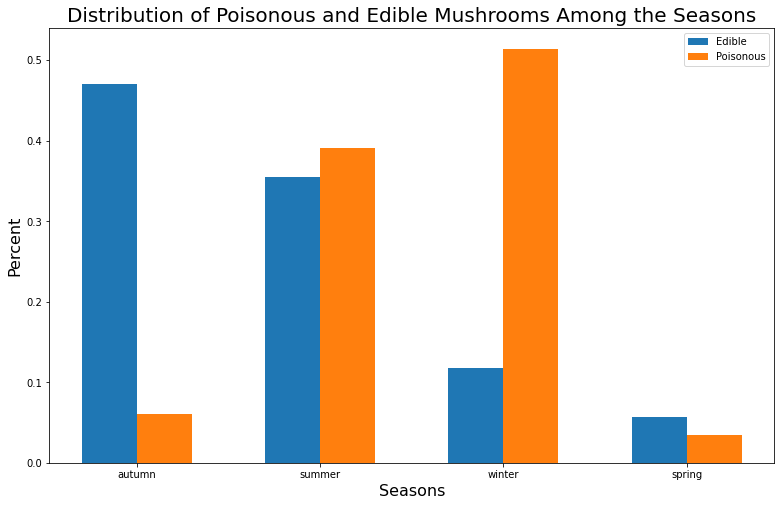

In [142]:
# Bar graph of the distribution of poisonous 
# and edible mushrooms by season.
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13, 8))
ax.bar(x = df.loc[df['class'] == 'edible', 'season'].unique(), 
       height = df.loc[df['class'] == 'edible', 'season'].value_counts(normalize = True),
       width = -0.3, align = 'edge',
       label = 'Edible')
ax.bar(x = df.loc[df['class'] == 'poisonous', 'season'].unique(),
       height = df.loc[df['class'] == 'poisonous', 'season'].value_counts(normalize = True),
       width = 0.3, align = 'edge',
       label = 'Poisonous')
ax.set_title(f'Distribution of Poisonous and Edible Mushrooms Among the Seasons', fontsize = 20)
ax.set_ylabel('Percent', fontsize = 16)
ax.set_xlabel('Seasons', fontsize = 16)
ax.legend();

> This bar graph suggests that the majority of the mushrooms that grow in autumn are edible, and that the majority of the mushrooms that grow in winter are poisonous. More of the mushrooms that grow in summer are poisonous, but there are still a good amount of edible mushrooms that grow in summer. Not many mushrooms grow in spring, and they are distributed about equally among poisonous and edible.
>
> Based on this graph, we would discourage the more amateur mushroom gatherers from gathering mushrooms in spring, summer, or winter. The amateur mushroom gatherer should stick to gathering mushrooms in autumn until they have more experience identifying edible mushrooms.

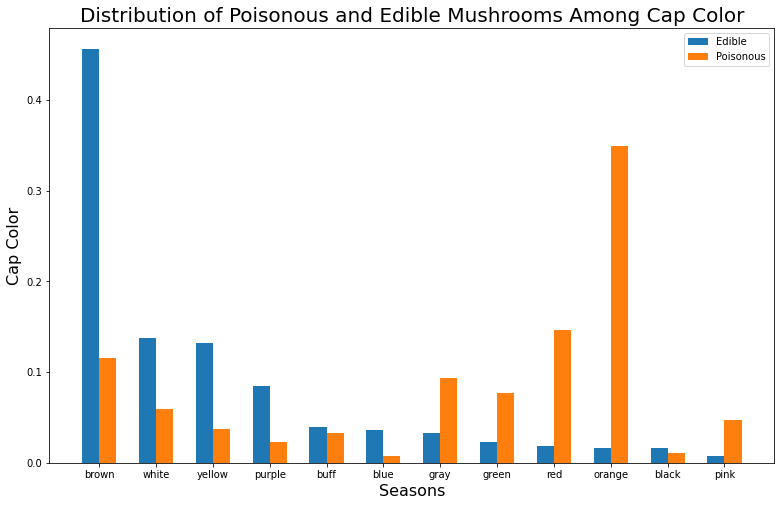

In [143]:
# Make bar graphs of the distribution of poisonous
# and edible mushrooms by cap-color.
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (13, 8))
ax.bar(x = df.loc[df['class'] == 'edible', 'cap-color'].unique(), 
       height = df.loc[df['class'] == 'edible', 'cap-color'].value_counts(normalize = True),
       width = -0.3, align = 'edge',
       label = 'Edible')
ax.bar(x = df.loc[df['class'] == 'poisonous', 'cap-color'].unique(),
       height = df.loc[df['class'] == 'poisonous', 'cap-color'].value_counts(normalize = True),
       width = 0.3, align = 'edge',
       label = 'Poisonous')
ax.set_title(f'Distribution of Poisonous and Edible Mushrooms Among Cap Color', fontsize = 20)
ax.set_ylabel('Cap Color', fontsize = 16)
ax.set_xlabel('Seasons', fontsize = 16)
ax.legend();

> Based on this graph we would advise the local leadership to strongly discourage the amateur mushroom foragers from gathering mushrooms with cap colors that are gray, green, red, orange, or pink. Orange mushrooms in particular tend to be toxic. While there are edible mushrooms with these cap colors, the majority tend to be poisonous.
>
> The mushrooms with cap colors of brown, white, yellow, purple, and blue tend to be the safest since they are majority edible. Brown seems to be the most safe, but caution should still be exercised as there are a significant amonut of poisonous mushrooms with brown caps. The amateur forager should start with known edible mushrooms with brown caps. After they have acquired some experience they can start looking for edible mushrooms with white, yellow, purple, or blue caps.

## Code for Part 4

### Preprocessing

In [144]:
# Check the balance of the target
ml_df['class'].value_counts(normalize = True)

p    0.553847
e    0.446153
Name: class, dtype: float64

> While this data is not perfectly balanced, it does not seem imbalanced enough to apply oversampling, undersampling, or stratification.

In [145]:
# Remind ourselves what data is missing
ml_df.isna().sum()

class                       0
cap-diameter                0
cap-shape                   0
cap-surface             14120
cap-color                   0
does-bruise-or-bleed        0
gill-attachment          9855
gill-spacing            25062
gill-color                  0
stem-height                 0
stem-width                  0
stem-color                  0
has-ring                    0
ring-type                2471
habitat                     0
season                      0
dtype: int64

In [146]:
# Check the data type of the missing data
filter = ml_df.isna().any() > 0
ml_df.loc[:, filter].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60923 entries, 0 to 61068
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cap-surface      46803 non-null  object
 1   gill-attachment  51068 non-null  object
 2   gill-spacing     35861 non-null  object
 3   ring-type        58452 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


> All the missing data is categorical. This will be imputed with a 'missing' label.

In [147]:
# Set the features and target
X = ml_df.drop(columns = 'class')
y = ml_df['class']

In [148]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [149]:
# Make a preprocessing column transformer

# Make column selectors
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

# Make a pipeline for the categorical data
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 'M'),
                         OneHotEncoder(sparse = False, handle_unknown = 'ignore'))

# Make tuples for the column transformer
num_tuple = (StandardScaler(), num_selector)
cat_tuple = (cat_pipe, cat_selector)

# Make the column transformer
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

### Modeling

#### Decision Tree

In [150]:
# Make a default decision tree
dt = make_pipeline(col_transformer, DecisionTreeClassifier())

In [151]:
# Train the decision tree
dt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5410>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='M',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5050>)])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [152]:
# Evaluate the decision tree
train_preds = dt.predict(X_train)
test_preds = dt.predict(X_test)

print('*'*19 + ' Train Metrics ' + '*'*19)
print(classification_report(y_train, train_preds))
print('\n' + '*'*20 + ' Test Metrics ' + '*'*19)
print(classification_report(y_test, test_preds))

******************* Train Metrics *******************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00     20448
           p       1.00      1.00      1.00     25244

    accuracy                           1.00     45692
   macro avg       1.00      1.00      1.00     45692
weighted avg       1.00      1.00      1.00     45692


******************** Test Metrics *******************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      6733
           p       1.00      1.00      1.00      8498

    accuracy                           1.00     15231
   macro avg       1.00      1.00      1.00     15231
weighted avg       1.00      1.00      1.00     15231



#### Logistic Regression

In [153]:
# Make a default logistic regression model
lr = make_pipeline(col_transformer, LogisticRegression(max_iter = 1000))

In [154]:
# Train the logistic regression model
lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5410>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='M',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5050>)])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [155]:
# Evaluate the logistic regression model
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

print('*'*19 + ' Train Metrics ' + '*'*19)
print(classification_report(y_train, train_preds))
print('\n' + '*'*20 + ' Test Metrics ' + '*'*19)
print(classification_report(y_test, test_preds))

******************* Train Metrics *******************
              precision    recall  f1-score   support

           e       0.75      0.77      0.76     20448
           p       0.81      0.79      0.80     25244

    accuracy                           0.78     45692
   macro avg       0.78      0.78      0.78     45692
weighted avg       0.78      0.78      0.78     45692


******************** Test Metrics *******************
              precision    recall  f1-score   support

           e       0.74      0.77      0.76      6733
           p       0.81      0.79      0.80      8498

    accuracy                           0.78     15231
   macro avg       0.78      0.78      0.78     15231
weighted avg       0.78      0.78      0.78     15231



##### Tune the logistic regression model

In [156]:
# Get the hyperparameters of the logistic regression model
lr.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5410>),
                                   ('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='M',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5050>)])),
  ('logisticregression', LogisticRegression(max_it

In [157]:
# Make a grid param dictionary for grid search
param_grid = {'logisticregression__C': np.float_power(10, range(-5, 5)),
              'logisticregression__max_iter': [1000],
              'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__solver': ['liblinear']}

In [158]:
# Perform grid search on the logistic regression model
lr_gs = GridSearchCV(lr, param_grid)
lr_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5410>),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='M',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5050>)])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04]),
                         'logisticregression__max_iter': [1000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear']})

In [159]:
# Get the best parameters for the logistic regression model
lr_gs.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__max_iter': 1000,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

> Tuning the logistic regression model showed no detectable improvements in precesion, recall, or accuracy.

In [160]:
# Evaluate the tuned model
best_lr = lr_gs.best_estimator_
train_preds = best_lr.predict(X_train)
test_preds = best_lr.predict(X_test)

print('*'*19 + ' Train Metrics ' + '*'*19)
print(classification_report(y_train, train_preds))
print('\n' + '*'*20 + ' Test Metrics ' + '*'*19)
print(classification_report(y_test, test_preds))

******************* Train Metrics *******************
              precision    recall  f1-score   support

           e       0.75      0.77      0.76     20448
           p       0.81      0.79      0.80     25244

    accuracy                           0.78     45692
   macro avg       0.78      0.78      0.78     45692
weighted avg       0.78      0.78      0.78     45692


******************** Test Metrics *******************
              precision    recall  f1-score   support

           e       0.75      0.77      0.76      6733
           p       0.81      0.79      0.80      8498

    accuracy                           0.78     15231
   macro avg       0.78      0.78      0.78     15231
weighted avg       0.78      0.78      0.78     15231



#### Bagged Tree Model

In [161]:
# Make a default bagged tree model
bt = make_pipeline(col_transformer, BaggingClassifier())

In [162]:
# Fit the bagged tree model
bt.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5410>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='M',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5050>)])),
                ('baggingclassifier', BaggingClassifier())])

In [163]:
# Evaluate the bagged tree model
train_preds = bt.predict(X_train)
test_preds = bt.predict(X_test)

print('*'*19 + ' Train Metrics ' + '*'*19)
print(classification_report(y_train, train_preds))
print('\n' + '*'*20 + ' Test Metrics ' + '*'*19)
print(classification_report(y_test, test_preds))

******************* Train Metrics *******************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00     20448
           p       1.00      1.00      1.00     25244

    accuracy                           1.00     45692
   macro avg       1.00      1.00      1.00     45692
weighted avg       1.00      1.00      1.00     45692


******************** Test Metrics *******************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      6733
           p       1.00      1.00      1.00      8498

    accuracy                           1.00     15231
   macro avg       1.00      1.00      1.00     15231
weighted avg       1.00      1.00      1.00     15231



#### Random Forest

In [164]:
# Make a default random forest model
rf = make_pipeline(col_transformer, RandomForestClassifier())

In [165]:
# Train the random forest model
rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5410>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='M',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5050>)])),
                ('randomforestclassifier', RandomForestClassifier())])

In [166]:
# Evaluate the random forest
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print('*'*19 + ' Train Metrics ' + '*'*19)
print(classification_report(y_train, train_preds))
print('\n' + '*'*20 + ' Test Metrics ' + '*'*19)
print(classification_report(y_test, test_preds))

******************* Train Metrics *******************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00     20448
           p       1.00      1.00      1.00     25244

    accuracy                           1.00     45692
   macro avg       1.00      1.00      1.00     45692
weighted avg       1.00      1.00      1.00     45692


******************** Test Metrics *******************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      6733
           p       1.00      1.00      1.00      8498

    accuracy                           1.00     15231
   macro avg       1.00      1.00      1.00     15231
weighted avg       1.00      1.00      1.00     15231



#### Principal Component Analysis
- Most of our models had perfect scores for accuracy, precision, and recall. We will still apply PCA in spite of this. PCA could still be helpful for this data set if we imagince a scenario where our clients are using a mobile based application to classify mushrooms.

In [167]:
# Instantiate a PCA object
pca = PCA(n_components = 0.95)

##### Decision Tree PCA

In [168]:
# Apply PCA to the decision tree
dt_pca = make_pipeline(col_transformer, pca, DecisionTreeClassifier())
dt_pca.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5410>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='M',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5050>)])),
                ('pca', PCA(n_components=0.95)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [169]:
%%time
# We will compare the time it takes the decision tree to make 
# predictions using the decision tree with and without PCA
dt_pca_preds = dt_pca.predict(X_test)

CPU times: user 89.8 ms, sys: 12.1 ms, total: 102 ms
Wall time: 87.5 ms


In [170]:
%%time
dt_preds = dt.predict(X_test)

CPU times: user 118 ms, sys: 75.1 ms, total: 193 ms
Wall time: 115 ms


In [171]:
# Compare the metrics of the two sets of predictions
print('*'*17+ ' Metrics With PCA ' + '*'*18)
print(classification_report(y_test, dt_pca_preds))
print('\n' + '*'*16 + ' Metrics Without PCA ' + '*'*16)
print(classification_report(y_test, dt_preds))

***************** Metrics With PCA ******************
              precision    recall  f1-score   support

           e       0.99      0.99      0.99      6733
           p       0.99      0.99      0.99      8498

    accuracy                           0.99     15231
   macro avg       0.99      0.99      0.99     15231
weighted avg       0.99      0.99      0.99     15231


**************** Metrics Without PCA ****************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      6733
           p       1.00      1.00      1.00      8498

    accuracy                           1.00     15231
   macro avg       1.00      1.00      1.00     15231
weighted avg       1.00      1.00      1.00     15231



> It is not worth applying PCA to the decision tree as the performance improvement appeared to be negligible and the loss of accuracy is unacceptable for our application of classifying mushrooms.

##### Bagged Tree PCA

In [172]:
# Apply PCA to the bagged tree model
bt_pca = make_pipeline(col_transformer, pca, BaggingClassifier())
bt_pca.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5410>),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='M',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1b476d5050>)])),
                ('pca', PCA(n_components=0.95)),
                ('baggingclassifier', BaggingClassifier())])

In [173]:
%%time
# Time the predictions using PCA
bt_pca_preds = bt_pca.predict(X_test)

CPU times: user 219 ms, sys: 105 ms, total: 324 ms
Wall time: 204 ms


In [174]:
%%time
# Time the predictions without PCA
bt_preds = bt.predict(X_test)

CPU times: user 249 ms, sys: 9.95 ms, total: 259 ms
Wall time: 261 ms


In [175]:
# Compare the metrics of the two sets of predictions
print('*'*17+ ' Metrics With PCA ' + '*'*18)
print(classification_report(y_test, bt_pca_preds))
print('\n' + '*'*16 + ' Metrics Without PCA ' + '*'*16)
print(classification_report(y_test, bt_preds))

***************** Metrics With PCA ******************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      6733
           p       1.00      1.00      1.00      8498

    accuracy                           1.00     15231
   macro avg       1.00      1.00      1.00     15231
weighted avg       1.00      1.00      1.00     15231


**************** Metrics Without PCA ****************
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      6733
           p       1.00      1.00      1.00      8498

    accuracy                           1.00     15231
   macro avg       1.00      1.00      1.00     15231
weighted avg       1.00      1.00      1.00     15231

